### Res Net

## demo

In [3]:
from torchvision import datasets
import torch 
import numpy as np


device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
tensor = torch.tensor([[1, 2, 3],
                       [4, 5, 6],
                       [7, 8, 9]], dtype=torch.float64)
print(tensor.to(device))


tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]], dtype=torch.float64)


## actual

In [3]:
import torch 
import numpy as np
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"


In [4]:
print(device)


cpu


: 

# Dataset


In [38]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose
from torchvision import transforms  
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
import numpy as np


from sklearn.model_selection import train_test_split

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
tf = Compose([
     transforms.ToTensor(),
     transforms.ConvertImageDtype(torch.float),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
     transforms.Pad(1)
 ])

class CustomCountriesDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=tf, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [42]:
df = pd.read_csv("C://Users//aidan//OneDrive//Desktop//New folder//output.csv")

X = df['images']
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
df = pd.concat([X_train,y_train ], axis = 1)

print(df)




31411    04.03.2024_105954_south-korea.jpg
42839         04.01.2024_044335_taiwan.jpg
17150        04.01.2024_005752_andorra.jpg
13           03.29.2024_193208_andorra.jpg
52270         04.02.2024_073410_taiwan.jpg
                       ...                
44732                                    3
54343                                    3
38158                                    2
860                                      0
15795                                    0
Length: 77790, dtype: object


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 226, 226])
Labels batch shape: torch.Size([64])


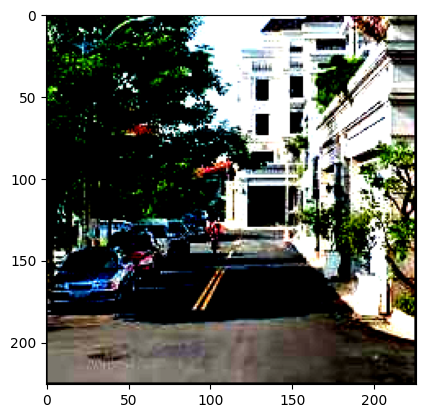

Label: 2
['andorra224x224', 'malta224x224', 'taiwan224x224']
{'andorra224x224': 0, 'malta224x224': 1, 'taiwan224x224': 2}


In [35]:


countries_dataset = ImageFolder("C://Users//aidan//OneDrive//Desktop//New folder//data", transform=tf,)


test_dataloader = DataLoader(countries_dataset, batch_size=64, shuffle=True)


train_features, train_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
image_np = img.numpy().transpose((1, 2, 0))
plt.imshow(image_np)
plt.show()
print(f"Label: {label}")


print(countries_dataset.classes)
print(countries_dataset.class_to_idx)

